In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

In [2]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '_mask.gif'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Binary mask

        if self.transform:
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path).convert("L"))
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


In [3]:
def get_transforms():
    return A.Compose([
        A.Crop(256, 256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

5088


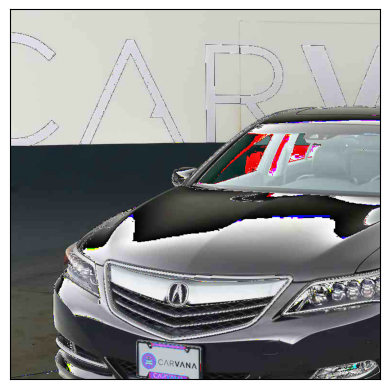

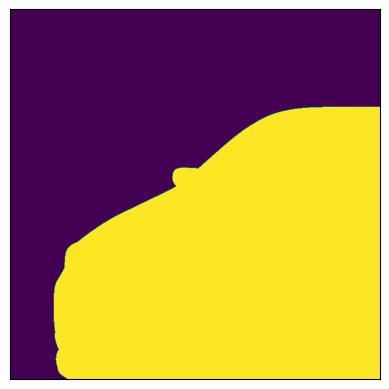

In [4]:
import nbimporter
import visualization

image_dir = 'D:/machine-learning/datasets/carvana/train/train'
mask_dir = 'D:/machine-learning/datasets/carvana/train_masks/train_masks'
transform = get_transforms()
dataset = CarvanaDataset(image_dir, mask_dir, transform)
print(len(dataset))
img, msk = dataset[1]
visualization.show(img)
visualization.show(msk)

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.double_conv(feature*2, feature))

        self.bottleneck = self.double_conv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )


In [6]:
def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    for batch_idx, (data, targets) in enumerate(loader):
        print(f'Batch {batch_idx}')
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        preds = model(data)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item():.4f}")


In [ ]:
def evaluate(model, loader, device, epoch):
    model.eval()
    to_pil = transforms.ToPILImage()
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1).float()
            preds = model(x)
            # You can visualize or calculate IoU here

            for pred in preds:
                x = to_pil(x)
                pred = to_pil(pred)
                if not os.path.exists(f'D:/machine-learning/datasets/carvana/preds/{epoch}/'):
                    os.mkdir('D:/machine-learning/datasets/carvana/preds/{epoch}/')
                
                x.save(f'D:/machine-learning/datasets/carvana/preds/{epoch}/{idx}_image.png')
                pred.save(f'D:/machine-learning/datasets/carvana/preds/{epoch}/{idx}_mask.png')

In [8]:
def main():
    image_dir = 'D:/machine-learning/datasets/carvana/train/train'
    mask_dir = 'D:/machine-learning/datasets/carvana/train_masks/train_masks'
    transform = get_transforms()

    dataset = CarvanaDataset(image_dir, mask_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        train_fn(loader, model, optimizer, loss_fn, device)
        evaluate(model, loader, device, epoch)

In [9]:
main()

Epoch 1/10
Batch 0
Loss: 12.4048
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Loss: 2.1318
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Loss: -3929.0513
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Loss: -11835.6377
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Loss: -13221.3701
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Loss: -16612.4141
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60


KeyboardInterrupt: 